In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import glob
import os
import pandas as pd
import netCDF4
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
regrid_files = sorted(glob.glob("/home/alubianashari/RAQMS_Regridded_GEMS_nc/tracer.202308*.nc"))
print(regrid_files)

['/home/alubianashari/RAQMS_Regridded_GEMS_nc/tracer.2023080100.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_GEMS_nc/tracer.2023080106.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_GEMS_nc/tracer.2023080112.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_GEMS_nc/tracer.2023080118.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_GEMS_nc/tracer.2023080200.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_GEMS_nc/tracer.2023080206.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_GEMS_nc/tracer.2023080212.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_GEMS_nc/tracer.2023080218.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_GEMS_nc/tracer.2023080300.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_GEMS_nc/tracer.2023080306.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_GEMS_nc/tracer.2023080312.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_GEMS_nc/tracer.2023080318.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_GEMS_nc/tracer.2023080400.5deg.ll.nc', '/home/alub

In [3]:
#grouping files by day
daily_files = {}
for f in regrid_files:
    filename = os.path.basename(f)
    timestamp = filename.split('.')[1]
    date_str = timestamp[:8]

    if date_str not in daily_files:
        daily_files[date_str] = [f]
    else:
        daily_files[date_str].append(f)
print(daily_files.keys())

dict_keys(['20230801', '20230802', '20230803', '20230804', '20230805', '20230806', '20230807', '20230808', '20230809', '20230810', '20230811', '20230812', '20230813', '20230814', '20230815', '20230816', '20230817', '20230818', '20230819', '20230820', '20230821', '20230822', '20230823', '20230824', '20230825', '20230826', '20230827', '20230828', '20230829', '20230830', '20230831'])


In [4]:
date = "20230802"
day_files = daily_files[date]

# Load all 4 RAQMS time files
datasets = xr.open_dataset(day_files[0])
lat = datasets['Latitude'] 
lon = datasets['Longitude']

ds_NO2_00 = np.array(datasets['no2tot'])
datasets = xr.open_dataset(day_files[1])
ds_NO2_06 = np.array(datasets['no2tot'])
datasets = xr.open_dataset(day_files[2])
ds_NO2_12 = np.array(datasets['no2tot'])
datasets = xr.open_dataset(day_files[3])
ds_NO2_18 = np.array(datasets['no2tot'])


ds_NO2 = np.stack([ds_NO2_00, ds_NO2_06, ds_NO2_12, ds_NO2_18], axis=0)
no2_daily_avg = np.nanmean(ds_NO2, axis=0) 

In [5]:
#check RAQMS shape and range
print(no2_daily_avg.shape)
print(lat.min().values, lat.max().values)
print(lon.min().values, lon.max().values)


(540, 750)
-5.950000000000766 47.95
70.05 144.94999999999575


In [6]:
#Load GEMS
date = "20230802"
gems_path = f"/ships22/raqms/Satellite/GEMS/L3/NO2/GK2_GEMS_L3_{date}_NO2_GRID-EA_daily_010.nc"


src = netCDF4.Dataset(gems_path)

# Extract NO₂, lat, lon
gems_no2 = np.array(src.groups['Data Fields'].variables['ColumnAmountNO2'][:])
gems_lat = np.array(src.groups['Geolocation Fields'].variables['Latitude'][:])
gems_lon = np.array(src.groups['Geolocation Fields'].variables['Longitude'][:])

# Handle fill value and scale units
fv = src.groups['Data Fields'].variables['ColumnAmountNO2'].getncattr('_FillValue') \
     if '_FillValue' in src.groups['Data Fields'].variables['ColumnAmountNO2'].ncattrs() else -9999


# Apply fill value and convert units
gems_no2 = np.where(gems_no2 == fv, np.nan, gems_no2 / 1e16)  #convert to 10¹⁶ molec/cm²

# create mask for cloud cover
cloud_mask = np.isnan(gems_no2)


In [7]:
# check GEMS shapes and ranges
print(gems_no2.shape)
print(gems_lat.min(), gems_lat.max())
print( gems_lon.min(), gems_lon.max())

(540, 750)
-5.950000000000766 47.95
70.05 144.94999999999575


In [8]:
# check mask
print(cloud_mask.shape)

(540, 750)


In [9]:
# Apply mask to RAQMS daily average
raqms_masked = np.where(cloud_mask, np.nan, no2_daily_avg)

# check shape
print( raqms_masked.shape)


(540, 750)


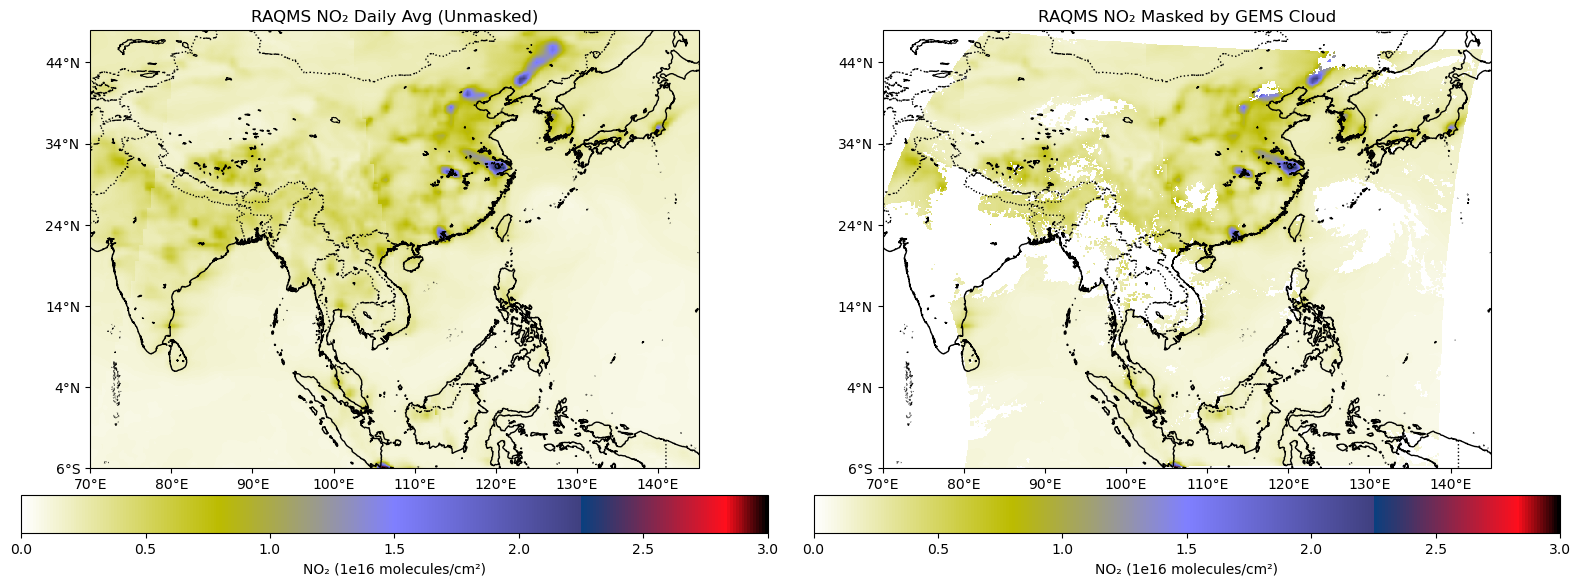

In [10]:
# === Helper functions ===
def plot_background(ax):
    ax.add_feature(cf.LAKES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.8)
    ax.add_feature(cf.COASTLINE.with_scale('10m'), linewidth=1)
    ax.add_feature(cf.BORDERS.with_scale('10m'), linestyle=':')
    return ax

def plot_ticks(ax, lon_min, lon_max, lat_min, lat_max):
    ax.set_xticks(np.arange(np.floor(lon_min), np.ceil(lon_max)+1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.floor(lat_min), np.ceil(lat_max)+1, 10), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol='°'))
    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol='°'))
    return ax

# Define lat lon
lon_min, lon_max = 70, 145
lat_min, lat_max = -6, 48


fig, axs = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Unmasked RAQMS
ax = axs[0]
p0 = ax.pcolormesh(lon, lat, no2_daily_avg, cmap="gist_stern_r", vmin=0, vmax=3, transform=ccrs.PlateCarree())
plot_background(ax)
plot_ticks(ax, lon_min, lon_max, lat_min, lat_max)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.set_title("RAQMS NO₂ Daily Avg (Unmasked)")
plt.colorbar(p0, ax=ax, orientation="horizontal", pad=0.05, label='NO₂ (1e16 molecules/cm²)')

# Cloud-masked RAQMS
ax = axs[1]
p1 = ax.pcolormesh(lon, lat, raqms_masked, cmap="gist_stern_r", vmin=0, vmax=3, transform=ccrs.PlateCarree())
plot_background(ax)
plot_ticks(ax, lon_min, lon_max, lat_min, lat_max)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.set_title("RAQMS NO₂ Masked by GEMS Cloud")
plt.colorbar(p1, ax=ax, orientation='horizontal', pad=0.05, label='NO₂ (1e16 molecules/cm²)')


plt.tight_layout()
plt.show()


In [12]:
# plot

# Helper functions to plot
def plot_background(ax):
    ax.add_feature(cf.LAKES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.8)
    ax.add_feature(cf.COASTLINE.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=1)
    ax.add_feature(cf.BORDERS.with_scale('10m'), linestyle=':')
    return ax

def plot_ticks(ax, lon_min, lon_max, lat_min, lat_max):
    ax.set_xticks(np.arange(np.floor(lon_min), np.ceil(lon_max)+1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.floor(lat_min), np.ceil(lat_max)+1, 10), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(number_format='.0f', degree_symbol='°'))
    ax.yaxis.set_major_formatter(LatitudeFormatter(number_format='.0f', degree_symbol='°'))
    return ax

raqms_dir = "/home/alubianashari/RAQMS_Regridded_GEMS_nc/"
gems_dir = "/ships22/raqms/Satellite/GEMS/L3/NO2/"
output_dir = "RAQMS_GEMS_Final_Fig_rev"
os.makedirs(output_dir, exist_ok=True)

#grouping files by day
regrid_files = sorted(glob.glob(f"{raqms_dir}/tracer.202308*.nc"))
daily_files = {}
for f in regrid_files:
    filename = os.path.basename(f)
    date_str = filename.split('.')[1][:8]
    daily_files.setdefault(date_str, []).append(f)

# store daily data
daily_results = {}

# process each day
for date, day_files in daily_files.items():

    # Load RAQMS NO₂
    ds = xr.open_dataset(day_files[0])
    lat = ds["Latitude"].values
    lon = ds["Longitude"].values
    no2_00 = xr.open_dataset(day_files[0])["no2tot"].values
    no2_06 = xr.open_dataset(day_files[1])["no2tot"].values
    no2_12 = xr.open_dataset(day_files[2])["no2tot"].values
    no2_18 = xr.open_dataset(day_files[3])["no2tot"].values

    no2_stack = np.stack([no2_00, no2_06, no2_12, no2_18], axis=0)
    no2_daily_avg = np.nanmean(no2_stack, axis=0)

    # Load and mask GEMS
    gems_path = os.path.join(gems_dir, f"GK2_GEMS_L3_{date}_NO2_GRID-EA_daily_010.nc")
    if not os.path.exists(gems_path):
        print(f"Skipping {date}")
        continue
    
    src = netCDF4.Dataset(gems_path)
    gems_raw = np.array(src.groups['Data Fields'].variables['ColumnAmountNO2'][:])
    fv = src.groups['Data Fields'].variables['ColumnAmountNO2'].getncattr('_FillValue') \
     if '_FillValue' in src.groups['Data Fields'].variables['ColumnAmountNO2'].ncattrs() else -9999
    gems_no2 = np.where(gems_raw == fv, np.nan, gems_raw / 1e16)
    raqms_masked = np.where(np.isnan(gems_no2), np.nan, no2_daily_avg)

    # Store results
    daily_results[date] = {
        "no2_daily_avg": no2_daily_avg,
        "no2_cloud_masked": raqms_masked,
        "gems_no2": gems_no2,
        "lat": lat,
        "lon": lon
    }

    # Plot
    fig = plt.figure(figsize=(10, 6), dpi=150)
    ax = plt.axes(projection=ccrs.PlateCarree())
        
    lon_min, lon_max = lon.min(), lon.max()
    lat_min, lat_max = lat.min(), lat.max()
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        
    plot_background(ax)
    plot_ticks(ax, lon_min, lon_max, lat_min, lat_max)
        
    mesh = ax.pcolormesh(lon, lat, raqms_masked, cmap="gist_stern_r", vmin=0, vmax=3, transform=ccrs.PlateCarree())
    plt.colorbar(mesh, orientation='horizontal', label='Column Amount NO₂ (10¹⁶ molecules/cm²)', fraction=0.046, pad=0.1)
        
    title_date = f"{date[:4]}-{date[4:6]}-{date[6:]}"
    ax.set_title(f"RAQMS Total Column NO₂ (Cloud-Masked by GEMS) – {title_date}")
        
    plt.savefig(f"{output_dir}/RAQMS_CloudMasked_{date}.png", facecolor='white', bbox_inches='tight')
    plt.close()


Skipping 20230801


In [13]:
save_dir = "/home/alubianashari/RAQMS_CloudMasked_GEMS/"
os.makedirs(save_dir, exist_ok=True)

# Loop and save
for date, data in daily_results.items():
    # Extract 1D lat/lon from 2D arrays
    lat_1d = data["lat"][:, 0]
    lon_1d = data["lon"][0, :]

    # Create dataset
    ds_out = xr.Dataset(
        {
            "no2_daily_avg": (("lat", "lon"), data["no2_daily_avg"]),
            "no2_cloud_masked": (("lat", "lon"), data["no2_cloud_masked"]),
            "gems_no2": (("lat", "lon"), data["gems_no2"])
        },
        coords={
            "lat": lat_1d,
            "lon": lon_1d
        }
    )

    # Save to file
    save_path = os.path.join(save_dir, f"tracer.compare.{date}.nc")
    ds_out.to_netcdf(save_path)


In [14]:
date = "20230802"
file_path = f"/home/alubianashari/RAQMS_CloudMasked_GEMS/tracer.compare.{date}.nc"

ds = xr.open_dataset(file_path)

print(ds)


<xarray.Dataset> Size: 6MB
Dimensions:           (lat: 540, lon: 750)
Coordinates:
  * lat               (lat) float64 4kB 47.95 47.85 47.75 ... -5.75 -5.85 -5.95
  * lon               (lon) float64 6kB 70.05 70.15 70.25 ... 144.7 144.8 144.9
Data variables:
    no2_daily_avg     (lat, lon) float32 2MB ...
    no2_cloud_masked  (lat, lon) float32 2MB ...
    gems_no2          (lat, lon) float64 3MB ...


In [15]:
# Compute monthly mean
path = "/home/alubianashari/RAQMS_CloudMasked_GEMS/"
files = sorted(glob.glob(f"{path}/tracer.compare.202308*.nc"))

# List to hold daily masked RAQMS NO₂
masked_stack_raqms = []
masked_stack_gems = []

for f in files:
    ds = xr.open_dataset(f)
    masked_stack_raqms.append(ds["no2_cloud_masked"].values)
    masked_stack_gems.append(ds["gems_no2"].values)

# Stack and compute monthly mean
masked_stack_raqms = np.stack(masked_stack_raqms, axis=0)  # shape: (days, lat, lon)
masked_stack_gems = np.stack(masked_stack_gems, axis=0) 
no2_monthly_avg_raqms = np.nanmean(masked_stack_raqms, axis=0)
no2_monthly_avg_gems = np.nanmean(masked_stack_gems, axis=0)

# Load lat/lon 
lat = ds["lat"].values
lon = ds["lon"].values


/tmp/ipykernel_4106778/1759921523.py:17: RuntimeWarning: Mean of empty slice
  no2_monthly_avg_raqms = np.nanmean(masked_stack_raqms, axis=0)
/tmp/ipykernel_4106778/1759921523.py:18: RuntimeWarning: Mean of empty slice
  no2_monthly_avg_gems = np.nanmean(masked_stack_gems, axis=0)


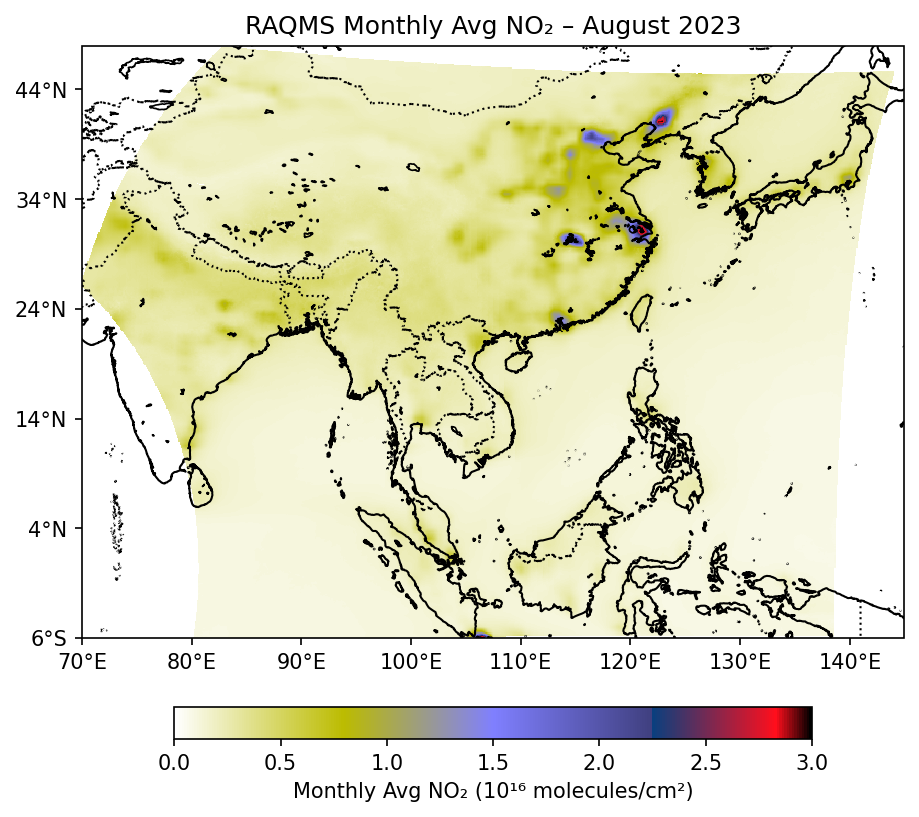

In [ ]:
# Plotting Monthly Average NO₂ RAQMS
def plot_background(ax):
    ax.add_feature(cf.LAKES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.8)
    ax.add_feature(cf.COASTLINE.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=1)
    ax.add_feature(cf.BORDERS.with_scale('10m'), linestyle=':')
    return ax

def plot_ticks(ax, lon_min, lon_max, lat_min, lat_max):
    ax.set_xticks(np.arange(np.floor(lon_min), np.ceil(lon_max)+1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.floor(lat_min), np.ceil(lat_max)+1, 10), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(number_format='.0f', degree_symbol='°'))
    ax.yaxis.set_major_formatter(LatitudeFormatter(number_format='.0f', degree_symbol='°'))
    return ax

# Plot
fig = plt.figure(figsize=(10, 6), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())

lon_min, lon_max = lon.min(), lon.max()
lat_min, lat_max = lat.min(), lat.max()
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

plot_background(ax)
plot_ticks(ax, lon_min, lon_max, lat_min, lat_max)

mesh = ax.pcolormesh(lon, lat, no2_monthly_avg_raqms, cmap="gist_stern_r", vmin=0, vmax=3, transform=ccrs.PlateCarree())
plt.colorbar(mesh, orientation='horizontal', label='Monthly Avg NO₂ (10¹⁶ molecules/cm²)', fraction=0.046, pad=0.1)

ax.set_title("RAQMS Monthly Avg NO₂ – August 2023")
plt.savefig("monthly_avg_GEMS/RAQMS_MonthlyAvg_Aug2023.png", facecolor='white', bbox_inches='tight')
plt.show()


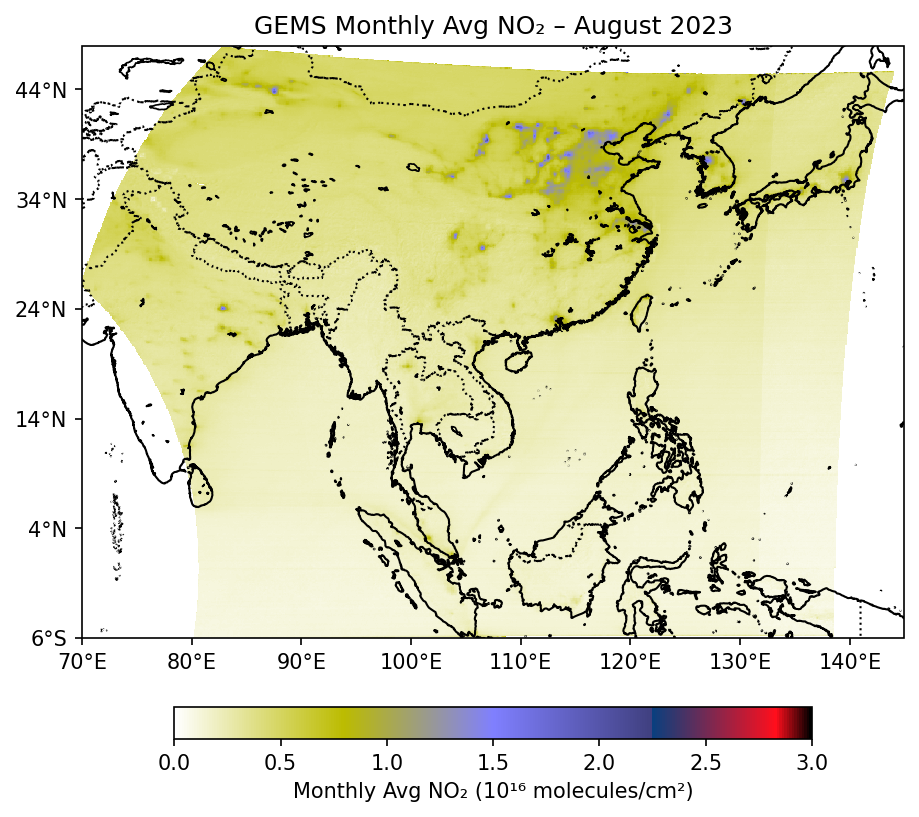

In [19]:
# Plotting Monthly Average NO₂ GEMS
def plot_background(ax):
    ax.add_feature(cf.LAKES.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=0.8)
    ax.add_feature(cf.COASTLINE.with_scale('10m'), facecolor='none', edgecolor='black', linewidth=1)
    ax.add_feature(cf.BORDERS.with_scale('10m'), linestyle=':')
    return ax

def plot_ticks(ax, lon_min, lon_max, lat_min, lat_max):
    ax.set_xticks(np.arange(np.floor(lon_min), np.ceil(lon_max)+1, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.floor(lat_min), np.ceil(lat_max)+1, 10), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(number_format='.0f', degree_symbol='°'))
    ax.yaxis.set_major_formatter(LatitudeFormatter(number_format='.0f', degree_symbol='°'))
    return ax

# Plot
fig = plt.figure(figsize=(10, 6), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())

lon_min, lon_max = lon.min(), lon.max()
lat_min, lat_max = lat.min(), lat.max()
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

plot_background(ax)
plot_ticks(ax, lon_min, lon_max, lat_min, lat_max)

mesh = ax.pcolormesh(lon, lat, no2_monthly_avg_gems, cmap="gist_stern_r", vmin=0, vmax=3, transform=ccrs.PlateCarree())
plt.colorbar(mesh, orientation='horizontal', label='Monthly Avg NO₂ (10¹⁶ molecules/cm²)', fraction=0.046, pad=0.1)

ax.set_title("GEMS Monthly Avg NO₂ – August 2023")
plt.savefig("monthly_avg_GEMS/GEMS_MonthlyAvg_Aug2023.png", facecolor='white', bbox_inches='tight')
plt.show()
